Let us first introduce a function that rewires a given percentage of arcs (keeping the same nodes and number of arcs)

In [80]:
import networkx as nx

def rewire(G, alpha=0.5):
    NG = nx.MultiDiGraph()
    NG.add_nodes_from(list(G.nodes()))
    for u, v in G.edges():
        label = qf.morph.new_arc_label(NG)
        if random.random()<alpha:
            source = random.choice(list(G.nodes()))
            target = random.choice(list(G.nodes()))
            qf.graphs.add_edges_with_name(NG, [(source, target, label)])
        else:
            qf.graphs.add_edges_with_name(NG, [(u, v, label)])
    return NG

## Evolution

In [1]:
import qf.cc
import qf.graphs
import qf.morph
import qf.qastar
import qf.qzss
import qf.util

In the `examples` directory there is a small graph representing the forward circuits in [*C. elegans*](https://en.wikipedia.org/wiki/Caenorhabditis_elegans) locomotion. 
Here is a small snippet of how the file looks like (this is the so-called *sparse* graph format; the library also allows for an alternative *dense* format, see the API documentation for details).

In [2]:
!head examples/graph.tsv

In the current implementation, weights are ignored. If available, it is convenient to associate to the nodes a position
that is used when visualizing the network (otherwise, the layout will be forced using some standard algorithm). 
Here is how a coordinate file looks like:

In [3]:
!head examples/coordinates.txt

ID x y
PVCL 0.20492990246102952 0.38904538297008134
PVCR 0.821162664221713 0.3884954177072364
VB11 0.18578607086646964 0.8516677131901752
AVBL 0.20321179505072312 0.13166037592335944
AVBR 0.8232335352901196 0.13095097734108677
RIBL 0.2059375431400424 0.0
DB02 1.0 0.4708813535450987
DB03 0.8961887813790183 0.6592014193320896
DB04 0.9406869074245455 0.5762517466586051


We read in the graph and coordinates. The graph is a [`networkx.MultiDiGraph`](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) object, and coordinates (if present) are stored
as suitable node attributes.

In [4]:
G = qf.util.read_graph("examples/graph.tsv", coordinates=qf.util.read_coordinates("examples/coordinates.txt"))

Let us visualize the graph G:

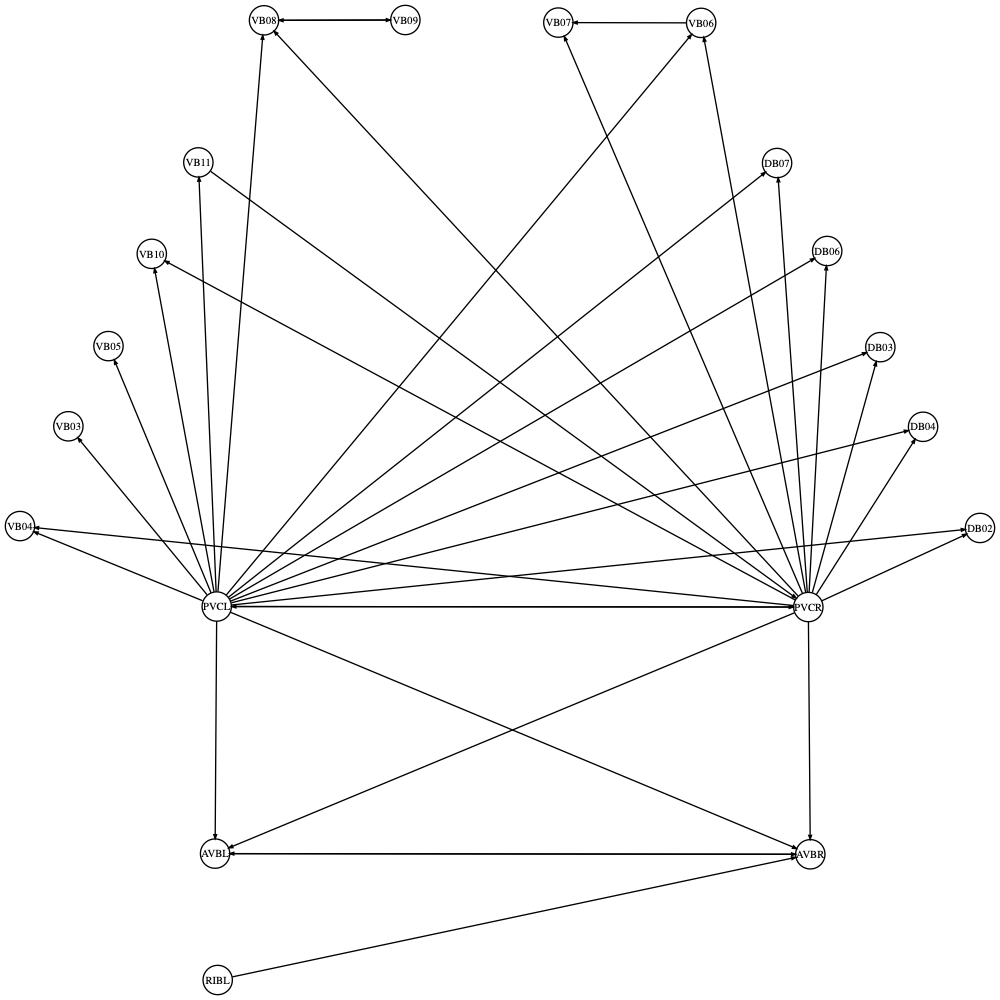

In [5]:
qf.graphs.visualize(G)

In the case of this dataset, we have an idea of how nodes should be clustered. This knowledge (that we shall hereafter
call *ground truth*) is stored in a file, and we can conveniently read it as follows:

In [6]:
gt = qf.util.read_label("examples/ground-truth.tsv")

We can use this dictionary to colour the graph, as follows:

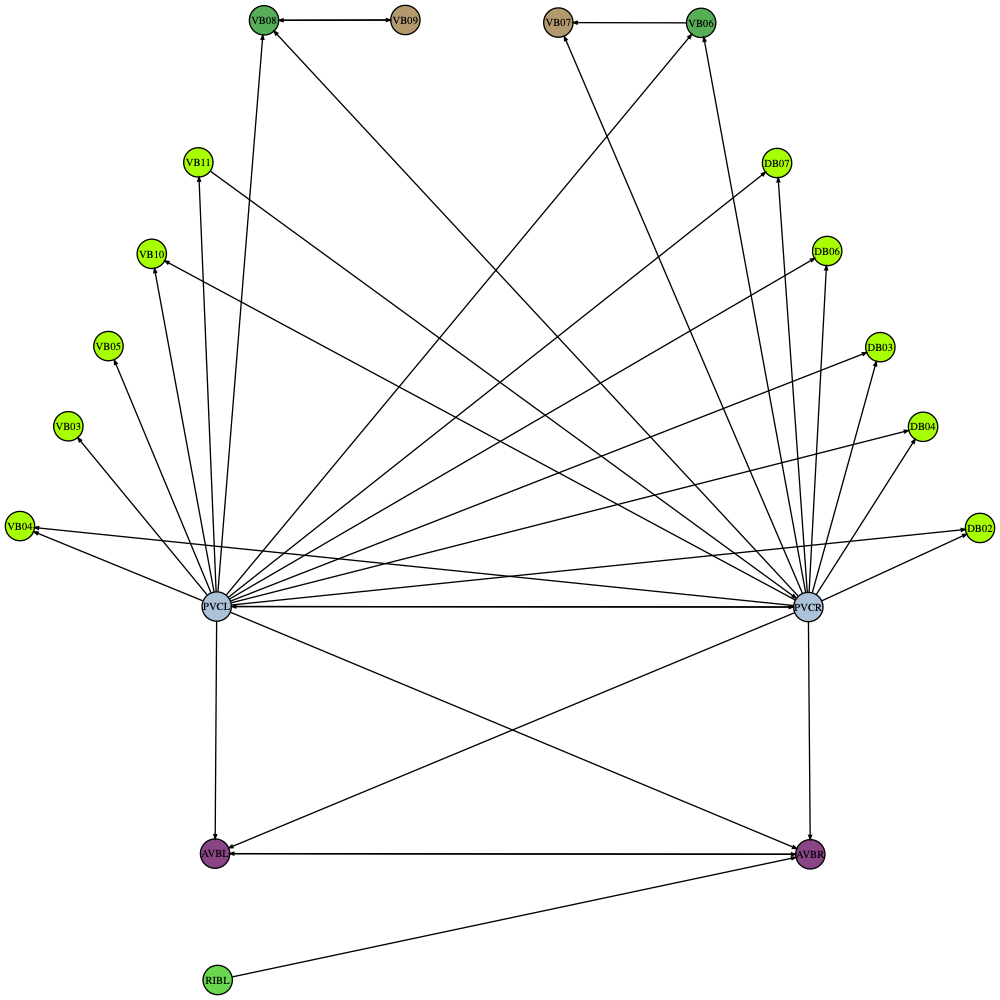

In [7]:
qf.graphs.visualize(G, gt)

Now we compute the optimal quasi-fibration from G with this equivalence classes as node fibres. The function returns the base graph and the fibration.

In [8]:
B, f = qf.morph.qf_build(G, gt)

Here is the excess and deficiency of this quasi-fibration.

In [9]:
gte, gtd = qf.morph.excess_deficiency(f, G, B)

Now, we show how to repair G so that f is transformed into a fibration. The function returns the new repaired graph and
the new morphism (an epimorphism).

In [10]:
Gp, fp = qf.morph.repair(f, G, B, verbose=True)

Adding arc new_arc_906691059: RIBL -> AVBL (mapped to 5_4_0)
Adding arc new_arc_813847339: VB09 -> VB06 (mapped to 6_3_0)
Adding arc new_arc_43469773: PVCR -> VB09 (mapped to 1_6_0)
Adding arc new_arc_548977048: PVCR -> VB11 (mapped to 1_2_1)
Adding arc new_arc_434794718: PVCR -> VB03 (mapped to 1_2_1)
Adding arc new_arc_511742081: PVCR -> VB05 (mapped to 1_2_1)
Adding arc new_arc_626401695: DB06 -> PVCL (mapped to 2_1_0)


# Scramble and check

In [11]:
import random

shres = []
for i in range(1000):
    gtv = list([gt[k] for k in gt.keys()])
    random.shuffle(gtv)
    gtsh = {k: gtv[i] for i,k in enumerate(gt.keys())}
    Bsh, fsh = qf.morph.qf_build(G, gtsh)
    gtshe, gtshd = qf.morph.excess_deficiency(fsh, G, Bsh)
    shres.append((gtshe,gtshd))

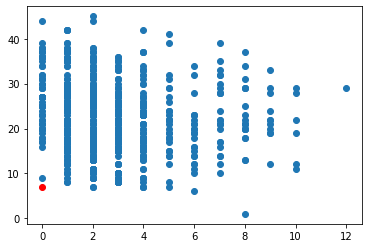

In [12]:
import matplotlib.pyplot as plt

plt.scatter([s[0] for s in shres], [s[1] for s in shres])
plt.scatter([gte], [gtd], color='red')
plt.show()

# Same for backward

In [13]:
G = qf.util.read_graph("../../Datasets/Shortcuts/backward-graph.tsv", coordinates=qf.util.read_coordinates("../../Datasets/Shortcuts/backward-coordinates.txt"))

In [14]:
gt = qf.util.read_label("../../Datasets/Shortcuts/backward-ground-truth.tsv")

In [15]:
B, f = qf.morph.qf_build(G, gt)
gte, gtd = qf.morph.excess_deficiency(f, G, B)

In [16]:
import random

shres = []
for i in range(1000):
    gtv = list([gt[k] for k in gt.keys()])
    random.shuffle(gtv)
    gtsh = {k: gtv[i] for i,k in enumerate(gt.keys())}
    Bsh, fsh = qf.morph.qf_build(G, gtsh)
    gtshe, gtshd = qf.morph.excess_deficiency(fsh, G, Bsh)
    shres.append((gtshe,gtshd))

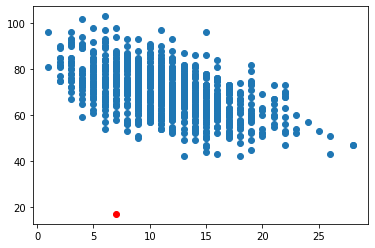

In [17]:
import matplotlib.pyplot as plt

plt.scatter([s[0] for s in shres], [s[1] for s in shres])
plt.scatter([gte], [gtd], color='red')
plt.show()

## Synthetic experiments: 30 nodes, rewiring 5% of the arcs

In [95]:
import qf.zssexp
import qf.cc
import qf.graphs

Gideal = qf.zssexp.get_fibration_rich_graph(30)
gt = qf.cc.cardon_crochemore(Gideal)
#G = qf.graphs.scramble(Gideal, nAdd=0, nDel=0, nScr=5)
G = rewire(Gideal, 0.05)

Original graph: n=30, nodes=30, arcs=60
Minimum base: nodes=10, arcs=60
Result: nodes=34, arcs=230


In [96]:
B, f = qf.morph.qf_build(G, gt)
gte, gtd = qf.morph.excess_deficiency(f, G, B)

# Synthetic experiments: 30 nodes, rewiring 20% of the arcs

In [81]:
import qf.zssexp
import qf.cc
import qf.graphs

Gideal = qf.zssexp.get_fibration_rich_graph(30)
gt = qf.cc.cardon_crochemore(Gideal)
#G = qf.graphs.scramble(Gideal, nAdd=0, nDel=0, nScr=5)
G = rewire(Gideal, 0.2)

Original graph: n=30, nodes=30, arcs=55
Minimum base: nodes=7, arcs=53
Result: nodes=20, arcs=117


In [82]:
B, f = qf.morph.qf_build(G, gt)
gte, gtd = qf.morph.excess_deficiency(f, G, B)

In [83]:
import random

shres = []
for i in range(1000):
    gtv = list([gt[k] for k in gt.keys()])
    random.shuffle(gtv)
    gtsh = {k: gtv[i] for i,k in enumerate(gt.keys())}
    Bsh, fsh = qf.morph.qf_build(G, gtsh)
    gtshe, gtshd = qf.morph.excess_deficiency(fsh, G, Bsh)
    shres.append((gtshe,gtshd))

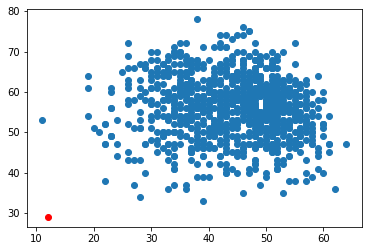

In [84]:
import matplotlib.pyplot as plt

plt.scatter([s[0] for s in shres], [s[1] for s in shres])
plt.scatter([gte], [gtd], color='red')
plt.show()

# Synthetic experiments: 30 nodes, rewiring 50% of the arcs

In [85]:
import qf.zssexp
import qf.cc
import qf.graphs

Gideal = qf.zssexp.get_fibration_rich_graph(30)
gt = qf.cc.cardon_crochemore(Gideal)
#G = qf.graphs.scramble(Gideal, nAdd=0, nDel=0, nScr=5)
G = rewire(Gideal, 0.5)

Original graph: n=30, nodes=30, arcs=71
Minimum base: nodes=9, arcs=71
Result: nodes=27, arcs=155


In [86]:
B, f = qf.morph.qf_build(G, gt)
gte, gtd = qf.morph.excess_deficiency(f, G, B)

In [87]:
import random

shres = []
for i in range(1000):
    gtv = list([gt[k] for k in gt.keys()])
    random.shuffle(gtv)
    gtsh = {k: gtv[i] for i,k in enumerate(gt.keys())}
    Bsh, fsh = qf.morph.qf_build(G, gtsh)
    gtshe, gtshd = qf.morph.excess_deficiency(fsh, G, Bsh)
    shres.append((gtshe,gtshd))

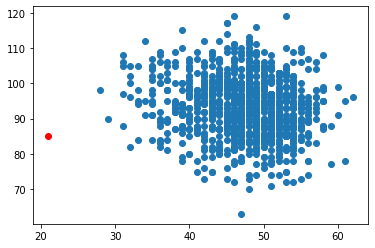

In [88]:
import matplotlib.pyplot as plt

plt.scatter([s[0] for s in shres], [s[1] for s in shres])
plt.scatter([gte], [gtd], color='red')
plt.show()

## Synthetic experiments: 30 nodes, rewiring 80% of the arcs

In [91]:
import qf.zssexp
import qf.cc
import qf.graphs

Gideal = qf.zssexp.get_fibration_rich_graph(30)
gt = qf.cc.cardon_crochemore(Gideal)
#G = qf.graphs.scramble(Gideal, nAdd=0, nDel=0, nScr=5)
G = rewire(Gideal, 0.8)

Original graph: n=30, nodes=30, arcs=61
Minimum base: nodes=9, arcs=61
Result: nodes=28, arcs=178


In [92]:
B, f = qf.morph.qf_build(G, gt)
gte, gtd = qf.morph.excess_deficiency(f, G, B)

In [93]:
import random

shres = []
for i in range(1000):
    gtv = list([gt[k] for k in gt.keys()])
    random.shuffle(gtv)
    gtsh = {k: gtv[i] for i,k in enumerate(gt.keys())}
    Bsh, fsh = qf.morph.qf_build(G, gtsh)
    gtshe, gtshd = qf.morph.excess_deficiency(fsh, G, Bsh)
    shres.append((gtshe,gtshd))

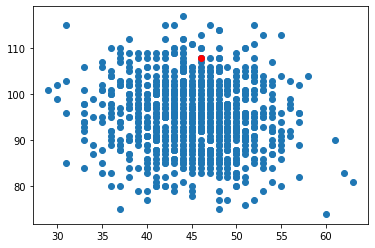

In [94]:
import matplotlib.pyplot as plt

plt.scatter([s[0] for s in shres], [s[1] for s in shres])
plt.scatter([gte], [gtd], color='red')
plt.show()